# Acoustic Wave Equation via Euler's method

## Introduction

In [1]:
import copy

import random
import math
import numpy as np
from inspect import isfunction

import torch
import torch.nn as nn

from tqdm import tqdm

from matplotlib import pyplot as plt

## Classes

### Class: `InitialConditions`

**Parent(s):** *none*

In [2]:
class InitialConditions():
    def __init__(self,
        start_time = 0.,
        masses = [1., 1., 1., 1.],
        charges = [.1, .1, .1, .1],
        initial_positions = [-3., -1., 1., 3.],
        initial_velocities = [3., -.5, -.5, -2.],
        boundary_charges = [1., 1.],
        boundary_positions = [-5., 5.]):
        
        assert isinstance(start_time, float)
        
        assert isinstance(masses,list)
        for m in masses:
            assert isinstance(m, float)
            assert m > 0.0
        
        assert isinstance(charges,list)
        for q in charges:
            assert isinstance(m, float)
        
        assert isinstance(initial_positions,list)
        for x in initial_positions:
            assert isinstance(x, float)
        for i in range(1,len(initial_positions)):
            assert initial_positions[i] > initial_positions[i-1]
        
        assert isinstance(initial_velocities,list)
        for v in initial_velocities:
            assert isinstance(v, float)
            
        assert len(masses) == len(charges) == len(initial_positions) == len(initial_velocities)
        
        assert isinstance(boundary_charges,list)
        assert len(boundary_charges) == 2
        for q in boundary_charges:
            assert isinstance(q, float)
        
        assert isinstance(boundary_positions,list)
        assert len(boundary_positions) == 2
        for x in boundary_positions:
            assert isinstance(x, float)
        boundary_positions[0] < min(initial_positions)
        boundary_positions[1] > max(initial_positions)
        
        self.start_time = start_time
        
        self.masses = masses
        self.charges = charges
        self.initial_positions = initial_positions
        self.initial_velocities = initial_velocities
        
        self.cardinality = len(self.masses)
        
        self.boundary_charges = boundary_charges
        self.boundary_positions = boundary_positions

Testing:

In [3]:
initial_conditions = InitialConditions()

### Class: `AcousticSystem`

In [4]:
class AcousticSystem():
    def __init__(self,
        initial_conditions = InitialConditions(),
        field_mesh_range = [-5., 5.],
        field_mesh_stride = .1):
        
        assert isinstance(initial_conditions, InitialConditions)
        
        assert isinstance(field_mesh_range, list)
        assert len(field_mesh_range) == 2
        for r in field_mesh_range:
            assert isinstance(r, float)
        field_mesh_range[0] < field_mesh_range[1]
        
        assert isinstance(field_mesh_stride, float)
        assert field_mesh_stride > 0.
        
        self.initial_conditions = initial_conditions
        self.field_mesh_range = field_mesh_range
        self.field_mesh_stride = field_mesh_stride
        self.mesh_step_count = math.floor((self.field_mesh_range[1]-self.field_mesh_range[0])/self.field_mesh_stride)
        
        self.start_time = self.initial_conditions.start_time
        
        self.masses = self.initial_conditions.masses
        self.charges = self.initial_conditions.charges
        self.initial_positions = self.initial_conditions.initial_positions
        self.initial_velocities = self.initial_conditions.initial_velocities
        
        self.cardinality = len(self.masses)
        
        self.boundary_charges = self.initial_conditions.boundary_charges
        self.boundary_positions = self.initial_conditions.boundary_positions
        
        self.time_history = [self.start_time]
        
        self.position_histories = []
        for x in self.initial_positions:
            self.position_histories.append([x])
        
        self.velocity_histories = []
        for v in self.initial_velocities:
            self.velocity_histories.append([v])
        
        self.acceleration_histories = [[0.] for m in self.masses]
        
        self.field_scalar_histories = [[0.] for step in range(self.mesh_step_count+2)]
        
        self.field_velocity_histories = [[0.] for step in range(self.mesh_step_count+2)]
        
        self.field_acceleration_histories = [[0.] for step in range(self.mesh_step_count+2)]
        
    
    def euler_step(self,
        speed_of_sound = 1.,
        charge_coupling = 1.,
        particle_width = .1,
        source_coupling = .01,
        time_stride = .1,
        drag = .1):
        
        last_time = self.time_history[-1]
        self.time_history.append(last_time + time_stride)

        for i in range(self.cardinality):
            # Use linear approximation to update the position and velocity of each particle:
            this_position = self.position_histories[i][-1]
            this_velocity = self.velocity_histories[i][-1]
            this_acceleration = self.acceleration_histories[i][-1]
            
            new_position = this_position + this_velocity * time_stride
            self.position_histories[i].append(new_position)
            new_velocity = this_velocity + this_acceleration * time_stride
            self.velocity_histories[i].append(new_velocity)
        
            # Use Coulomb's law + Newton's second law to update the acceleration of each particle:
            this_mass = self.masses[i]
            this_charge = self.charges[i]
            electrical_force = 0.0
            for j in range(self.cardinality):
                if j != i:
                    that_charge = self.charges[j]
                    charge_product = this_charge * that_charge
                    that_position = self.position_histories[j][-1]
                    position_difference = this_position - that_position
                    force_term = charge_coupling * charge_product * abs(position_difference)/(position_difference**3)
                    electrical_force += force_term
            for j in range(2):
                that_charge = self.boundary_charges[j]
                charge_product = this_charge * that_charge
                that_position = self.boundary_positions[j]
                position_difference = this_position - that_position
                force_term = charge_coupling * charge_product * abs(position_difference)/(position_difference**3)
                electrical_force += force_term
            new_acceleration = electrical_force / this_mass
            self.acceleration_histories[i].append(new_acceleration)
        
        
        self.field_scalar_histories[0].append(0.)
        self.field_scalar_histories[self.mesh_step_count+1].append(0.)
        self.field_velocity_histories[0].append(0.)
        self.field_velocity_histories[self.mesh_step_count+1].append(0.)
        self.field_acceleration_histories[0].append(0.)
        self.field_acceleration_histories[self.mesh_step_count+1].append(0.)
        for i in range(1, self.mesh_step_count+1):
            x = self.field_mesh_range[0] + self.field_mesh_stride * i
            
            this_scalar = self.field_scalar_histories[i][-1]
            previous_scalar = self.field_scalar_histories[i-1][-1]
            next_scalar = self.field_scalar_histories[i+1][-1]
            
            this_field_velocity = self.field_velocity_histories[i][-1]
            this_field_acceleration = self.field_acceleration_histories[i][-1]
            
            # Use linear approximation to update the value and velocity of our scalar field:
            new_scalar = this_scalar + this_field_velocity * time_stride
            self.field_scalar_histories[i].append(new_scalar)
            new_field_velocity = this_field_velocity + this_field_acceleration * time_stride
            self.field_velocity_histories[i].append(new_field_velocity)
            
            # Use acoustic wave equation to update teh acceleration of our scalar field:
            next_slope = (next_scalar - this_scalar)/self.field_mesh_stride
            previous_slope = (this_scalar - previous_scalar)/self.field_mesh_stride
            this_curvature = (next_slope - previous_slope)/self.field_mesh_stride
            new_field_acceleration = - drag * this_scalar + speed_of_sound * this_curvature
            for k in range(self.cardinality):
                particle_mass = self.masses[k]
                particle_position = self.position_histories[k][-2]
                dirac_approx = (1/(particle_width * np.sqrt(2*np.pi))) * np.exp(-(1/2)*((x - particle_position)/particle_width)**2)
                particle_acceleration = self.acceleration_histories[k][-2]
                particle_velocity = self.velocity_histories[k][-2]
                source_term = source_coupling * particle_acceleration * dirac_approx
                new_field_acceleration += source_term
            new_field_acceleration = .05 * new_field_acceleration
            self.field_acceleration_histories[i].append(new_field_acceleration)

Testing:

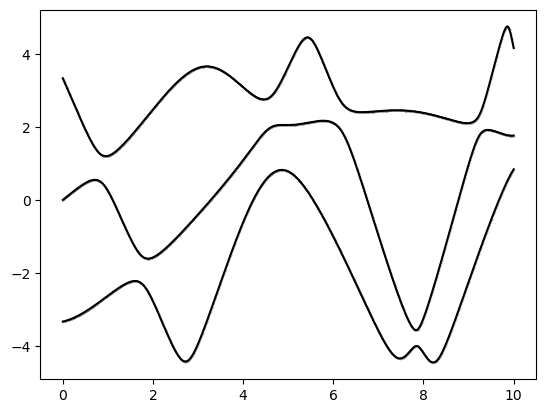

In [5]:
initial_conditions = InitialConditions(start_time = 0.,
                                       masses = [.01, .01, .01],
                                       charges = [1., 1., 1.],
                                       initial_positions = [-3.3333333, 0., 3.3333333],
                                       initial_velocities = [.3, 1., -2.75],
                                       boundary_charges = [1., 1.],
                                       boundary_positions = [-5., 5.])

acoustic_system = AcousticSystem(initial_conditions = initial_conditions,
                                 field_mesh_stride = .05)

for _ in range(1000):
    acoustic_system.euler_step(speed_of_sound = 1.5,
                               charge_coupling = .05,
                               particle_width = .025,
                               time_stride = .01, 
                               source_coupling = .1,
                               drag = 0.)

T = acoustic_system.time_history

for X in acoustic_system.position_histories:
    plt.plot(T, X, marker="o", markersize=.1,  color='k')
        
plt.show()

5.652868788790634
-5.819271239514928


100%|█████████████████████████████████████████| 202/202 [00:59<00:00,  3.38it/s]


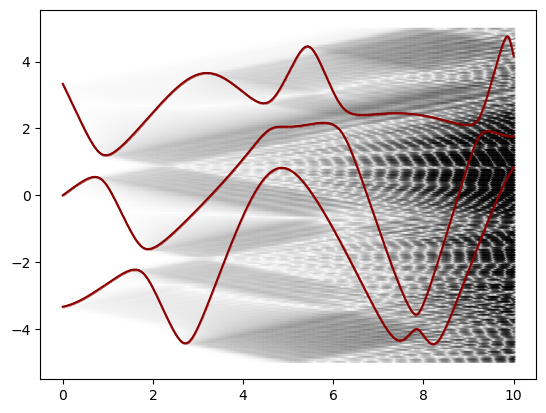

In [14]:
top = max([max([s for s in line]) for line in acoustic_system.field_scalar_histories])
bottom = min([min([s for s in line]) for line in acoustic_system.field_scalar_histories])
print(top)
print(bottom)

T = acoustic_system.time_history

for i in tqdm(range(len(acoustic_system.field_scalar_histories))):
    value_list = acoustic_system.field_scalar_histories[i]
    x = acoustic_system.field_mesh_range[0] + acoustic_system.field_mesh_stride * i
    for j, t in enumerate(T):
        scalar = acoustic_system.field_scalar_histories[i][j]
        cval2 = abs(np.tanh(scalar/.5))
        plt.plot([t], [x], marker=".", markersize=2 * .35, color=(1-cval2**(3/5), 1-cval2**(3/5), 1-cval2**(3/5)))
#        cval = np.tanh(scalar/.5)
#        plt.plot([t], [x], marker=".", markersize=2 * .35, color=((.75+cval/4)/2 + (1-cval2**(3/9))/2,
#                                                                  (.75+cval/4)/2 + (1-cval2**(3/9))/2,
#                                                                  (.75-cval/4)/2 + (1-cval2**(3/9))/2))

for X in acoustic_system.position_histories:
    plt.plot(T, X, marker="o", markersize=.1,  color='darkred')
        
plt.show()